# 1 基本准备工作

In [1]:
# filterwarnings函数可以让机器自动过滤掉对程序运行不会造成影响的警告提示，方便之后的操作
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 引入一些稍后需要用到的工具模块
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

In [3]:
# 读入基本数据表，该数据通过scrapy爬虫获取
data_table = pd.read_csv(r'player_performance.csv')

# 2 数据检查与预处理

In [4]:
# 查看数据
data_table.isnull().sum()
# 可以发现，数据属性中进名字name以及场上位置position这两个字符串类型的变量含有空值，不影响数据分析，在此可以忽略不管

assists               0
back_passes           0
blocked_passes        0
blocked_shots         0
clearances            0
crosses               0
diagonal_passes       0
dribbles              0
fouls                 0
foulsconceded         0
goals                 0
id                    0
interceptions         0
key_passes            0
lateral_passes        0
long_passes           0
minutesPlayed         0
name                 25
offsides              0
passes                0
position             25
possession_time       0
red_cards             0
saves                 0
season                0
short_passes          0
shots                 0
shots_on_target       0
succ_long_passes      0
succ_passes           0
succ_short_passes     0
tackles               0
through_passes        0
touches               0
yellow_cards          0
dtype: int64

In [7]:
dupdata = data_table.duplicated()
count = 0
for i in dupdata:
    if i:
        count = count + 1
print('total dup count', count)

total dup count 29


In [8]:
# 上述结果表明，数据集中存在重复项
data_table = data_table.drop_duplicates()

In [9]:
def Mean(arr):
    return arr.mean()

dataset = data_table.groupby(['id', 'season']).agg(Mean)
# 将基础数据根据球员ID以及赛季进行合并，以求得各位球员每赛季的场均数据

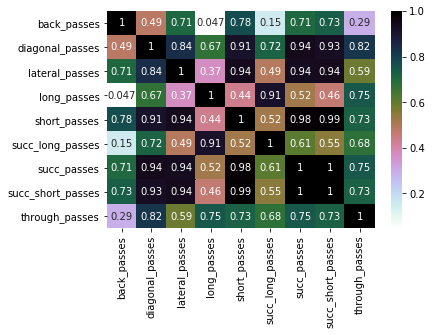

In [11]:
# 注意观察变量之间的相关程度，以尽可能避免多重线性回归
import seaborn as sns

# 由于变量较多，在此我仅根据经验选择9个与传球这一动作有关的变量绘制相关系数图
features = ['back_passes','diagonal_passes','lateral_passes','long_passes','short_passes','succ_long_passes','succ_passes',\
            'succ_short_passes','through_passes']

sns.heatmap(dataset[features].corr(),annot = True,cmap = 'cubehelix_r')
# 可以发现，相关系数图颜色较深，换言之，仅仅这9个变量就包含了不少重叠信息，降维在所难免

# 3 准备训练集与测试集

In [12]:
dataset.to_csv('D:\\avg_performance.csv',sep=',',header=True,index=True)
# 将球员们的场均数据写入CSV文件，用于主成分分析

In [3]:
dataset = pd.read_csv(r'PCA.csv')
dataset = dataset.set_index(['id', 'season'])

In [4]:
dataset.isnull().sum()

organization        0
attack              0
goalkeeping         0
key_pass            0
defence             0
defending_skills    0
wing_back           0
central_back        0
discipline          0
Rating              0
dtype: int64

In [5]:
dataset.isnull().sum()

organization        0
attack              0
goalkeeping         0
key_pass            0
defence             0
defending_skills    0
wing_back           0
central_back        0
discipline          0
Rating              0
dtype: int64

In [4]:
# 构造自变量矩阵
x = dataset.as_matrix(['organization','attack','goalkeeping','key_pass','defence','defending_skills','wing_back','central_back',\
                               'discipline'])

In [5]:
y = dataset.as_matrix(['Rating'])

In [6]:
# 在自变量矩阵加上7列全零矩阵，使得数据成为16维矩阵，以方便卷积网络的搭建
x = np.column_stack([x,np.zeros((len(x),7))])

In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, random_state=33)

In [8]:
# 数据标准化
# 即对矩阵任一元素x,令z = (x-u)/s，其中u表示x所在变量中的均值，s表示x所在变量中的标准方差
x_max_min = preprocessing.MinMaxScaler()
train_x = x_max_min.fit_transform(train_x)
test_x = x_max_min.transform(test_x)

y_max_min = preprocessing.MinMaxScaler()
train_y = y_max_min.fit_transform(train_y.reshape(-1,1))
test_y = y_max_min.transform(test_y.reshape(-1,1))

# 4 卷积网络的搭建

In [9]:
# 加权矩阵
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [10]:
# 偏置
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [11]:
#卷积处理 变厚过程
def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1] x_movement、y_movement就是步长
    # Must have strides[0] = strides[3] = 1 
    # padding='SAME'表示卷积后长宽不变
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [12]:
#pool 长宽缩小一倍
def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [13]:
# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 16]) #原始数据的维度：16
ys = tf.placeholder(tf.float32, [None, 1])#输出数据为维度：1

In [14]:
keep_prob = tf.placeholder(tf.float32)#dropout的比例

In [15]:
x_image = tf.reshape(xs, [-1, 4, 4, 1])#原始数据16变成二维图片4x4
## conv1 layer ##第一卷积层
W_conv1 = weight_variable([2,2, 1,32]) # patch 2x2, in size 1, out size 32,每个像素变成32个像素，就是变厚的过程
b_conv1 = bias_variable([32])
# h_conv1 = tf.nn.softplus(conv2d(x_image, W_conv1) + b_conv1) # output size 2x2x32，长宽不变，高度为32的三维图像
# h_conv1 = tf.nn.softsign(conv2d(x_image, W_conv1) + b_conv1)
# h_conv1 = tf.nn.sigmoid(conv2d(x_image, W_conv1) + b_conv1)
# h_conv1 = tf.nn.elu(conv2d(x_image, W_conv1) + b_conv1)
h_conv1 = tf.nn.tanh(conv2d(x_image, W_conv1) + b_conv1)
# h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
## conv2 layer ##第二卷积层
W_conv2 = weight_variable([2,2, 32, 64]) # patch 2x2, in size 32, out size 64
b_conv2 = bias_variable([64])
# h_conv2 = tf.nn.softplus(conv2d(h_conv1, W_conv2) + b_conv2) #输入第一层的处理结果 输出shape 4*4*64
# h_conv2 = tf.nn.softsign(conv2d(h_conv1, W_conv2) + b_conv2)
# h_conv2 = tf.nn.sigmoid(conv2d(h_conv1, W_conv2) + b_conv2)
# h_conv2 = tf.nn.elu(conv2d(h_conv1, W_conv2) + b_conv2)
h_conv2 = tf.nn.tanh(conv2d(h_conv1, W_conv2) + b_conv2)
# h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

In [17]:
## 池化层
h_pool1 = max_pool_2x2(h_conv2)     # output size 2x2x32 长宽缩小一倍

In [18]:
#  full connection 全连接层
W_fc1 = weight_variable([2*2*64, 512])#3x3 ，高度为64的三维图片，然后把它拉成512长的一维数组
b_fc1 = bias_variable([512])

In [19]:
h_pool2_flat = tf.reshape(h_pool1, [-1, 2*2*64])#把4*4，高度为64的三维图片拉成一维数组 降维处理
# h_fc1 = tf.nn.softplus(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1 = tf.nn.sigmoid(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1 = tf.nn.elu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1 = tf.nn.tanh(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1 = tf.nn.softsign(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)#把数组中扔掉比例为keep_prob的元素
## fc2 layer ## full connection
W_fc2 = weight_variable([512, 1])#512长的一维数组压缩成长度为1的数组
b_fc2 = bias_variable([1])#偏置

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
#最后的计算结果
prediction =  tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [34]:
# 计算 predition与y 差距 所用方法很简单就是用 suare()平方,sum()求和,mean()平均值
cross_entropy = pow(tf.losses.mean_squared_error(ys, prediction), 0.5)

In [33]:
std = pow(tf.reduce_mean(tf.square(tf.subtract(tf.subtract(ys, prediction), tf.reduce_mean(tf.subtract(ys, prediction))))), 0.5)

In [35]:
# 0.01学习效率,minimize(loss)减小loss误差
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

In [38]:
def CVKFold(k, x, y):
    from sklearn.model_selection import KFold
    
#     np.random.seed(1)
#     np.random.seed(2)
    np.random.seed(3)
    
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    train_rmse = [0 for i in range(k)]
    test_rmse = [0 for i in range(k)]
    train_std = [0 for i in range(k)]
    test_std = [0 for i in range(k)]
    
    idx = 0
    
    kf = KFold(n_splits = k, shuffle = True)
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
#         ss_x = preprocessing.StandardScaler()
#         x_train = ss_x.fit_transform(x_train)
#         x_test = ss_x.transform(x_test)
        x_max_min = preprocessing.StandardScaler()
        x_train = x_max_min.fit_transform(x_train)
        x_test = x_max_min.transform(x_test)
        
#         ss_y = preprocessing.StandardScaler()
#         y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1))
#         y_test = ss_y.transform(y_test.values.reshape(-1, 1))
        y_max_min = preprocessing.StandardScaler()
        y_train = y_max_min.fit_transform(y_train.values.reshape(-1,1))
        y_test = y_max_min.transform(y_test.values.reshape(-1,1))
        
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        for i in range(1):
            sess.run(train_step, feed_dict={xs: x_train, ys: y_train, keep_prob: 0.7})
        prediction_value = sess.run(prediction, feed_dict={xs: x_test, ys: y_test, keep_prob: 1.0})
        train_rmse[idx] = sess.run(cross_entropy, feed_dict={xs: x_train, ys: y_train, keep_prob: 1.0})
        train_std[idx] = sess.run(std, feed_dict={xs: x_train, ys: y_train, keep_prob: 1.0})
        print('第' + str(idx+1) + '次训练集误差=', train_rmse[idx])
        RMSE_SUM = 0
        stdvar = [0 for k in range(len(y_test))]
        for j in range(len(y_test)):
             stdvar[j] = prediction_value[j]-y_test[j]
             RMSE_SUM += pow(stdvar[j], 2)
        test_rmse[idx] = pow(RMSE_SUM/len(y_test),0.5)
        test_std[idx] = np.std(stdvar, ddof=1)    
        print('第' + str(idx+1) + '次测试集误差=', test_rmse[idx])
        idx += 1
    return train_rmse, test_rmse, train_std, test_std

In [40]:
train_accuracy, test_accuracy, train_std, test_std = CVKFold(5, train_x, train_y)

第1次训练集误差= 15.409615
第1次测试集误差= [15.42554179]
第2次训练集误差= 16.050499
第2次测试集误差= [16.28228327]
第3次训练集误差= 14.629851
第3次测试集误差= [14.66497183]
第4次训练集误差= 5.2516103
第4次测试集误差= [5.19145867]
第5次训练集误差= 15.849879
第5次测试集误差= [15.84995309]


In [43]:
tanh_train_rmse = np.mean(train_accuracy)
tanh_test_rmse = np.mean(test_accuracy)
tanh_train_std = np.mean(train_std)
tanh_test_std = np.mean(test_std)
tanh_train_rmse, tanh_test_rmse, tanh_train_std, tanh_test_std

(13.438291, 13.482841732168149, 1.4128879, 1.4413490198849368)

In [106]:
elu_train = np.mean(train_accuracy)
elu_test = np.mean(test_accuracy)
elu_std = np.mean(std)
elu_train, elu_test, elu_std

(0.13840964, 0.1993602785796794, 0.18554503096962666)

In [89]:
sigmoid_train = np.mean(train_accuracy)
sigmoid_test = np.mean(test_accuracy)
sigmoid_std = np.mean(std)
sigmoid_train, sigmoid_test, sigmoid_std

(0.20578456, 0.28170145934249813, 0.2579942185621823)

In [36]:
relu_train = np.mean(train_accuracy)
relu_test = np.mean(test_accuracy)
relu_std = np.mean(std)
relu_train, relu_test, relu_std

(0.13500085, 0.22913251335335239, 0.2864800292382203)

In [54]:
softplus_train = np.mean(train_accuracy)
softplus_test = np.mean(test_accuracy)
softplus_std = np.mean(std)
softplus_train, softplus_test, softplus_std

(0.16142914, 0.23051346532104872, 0.23485630808358335)

In [72]:
softsign_train = np.mean(train_accuracy)
softsign_test = np.mean(test_accuracy)
softsign_std = np.mean(std)
softsign_train, softsign_test, softsign_std

(0.087714106, 0.18937079691781739, 0.21422406336867517)

In [24]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    sess.run(train_step, feed_dict={xs: train_x, ys: train_y, keep_prob: 0.7})
    print( i+ 1, '误差=',sess.run(cross_entropy, feed_dict={xs: train_x, ys: train_y, keep_prob: 1.0}))  # 输出loss值

1 误差= 13.7015085
2 误差= 5.1017914
3 误差= 4.1591835
4 误差= 4.1261764
5 误差= 1.2360388
6 误差= 1.9332695
7 误差= 2.6355774
8 误差= 2.0443301
9 误差= 0.83773714
10 误差= 0.7962788
11 误差= 1.3303541
12 误差= 0.9627785
13 误差= 0.17921315
14 误差= 0.90529245
15 误差= 1.0547588
16 误差= 0.6748675
17 误差= 0.19010438
18 误差= 0.5273082
19 误差= 0.60765934
20 误差= 0.45272827
21 误差= 0.20829023
22 误差= 0.26350683
23 误差= 0.38297814
24 误差= 0.38214415
25 误差= 0.2965127
26 误差= 0.19082244
27 误差= 0.18664786
28 误差= 0.24210241
29 误差= 0.24411313
30 误差= 0.19278194
31 误差= 0.16249447
32 误差= 0.20649463
33 误差= 0.2327237
34 误差= 0.20761442
35 误差= 0.16448742
36 误差= 0.17234902
37 误差= 0.20109414
38 误差= 0.19837469
39 误差= 0.17081767
40 误差= 0.15900555
41 误差= 0.17561968
42 误差= 0.18373157
43 误差= 0.17122291
44 误差= 0.15684462
45 误差= 0.15950681
46 误差= 0.16858219
47 误差= 0.16825573
48 误差= 0.15905757
49 误差= 0.15204455
50 误差= 0.15403956
51 误差= 0.15815942
52 误差= 0.15608263
53 误差= 0.14926445
54 误差= 0.1453101
55 误差= 0.1467667
56 误差= 0.14797534
57 误差= 0.14477593


425 误差= 0.019097297
426 误差= 0.020305369
427 误差= 0.015616611
428 误差= 0.01694449
429 误差= 0.018838402
430 误差= 0.020362845
431 误差= 0.015412852
432 误差= 0.015694609
433 误差= 0.016944552
434 误差= 0.021361418
435 误差= 0.016989324
436 误差= 0.015438601
437 误差= 0.016349474
438 误差= 0.020967266
439 误差= 0.018033454
440 误差= 0.016558915
441 误差= 0.016569274
442 误差= 0.019411441
443 误差= 0.017498886
444 误差= 0.01773856
445 误差= 0.017715747
446 误差= 0.019443477
447 误差= 0.016923506
448 误差= 0.016290179
449 误差= 0.016584609
450 误差= 0.019953696
451 误差= 0.017581863
452 误差= 0.01763015
453 误差= 0.01734516
454 误差= 0.019501155
455 误差= 0.016591884
456 误差= 0.016030565
457 误差= 0.016037459
458 误差= 0.020225625
459 误差= 0.018125439
460 误差= 0.017133692
461 误差= 0.015745038
462 误差= 0.017238703
463 误差= 0.018363692
464 误差= 0.01957361
465 误差= 0.016772106
466 误差= 0.016603557
467 误差= 0.016702417
468 误差= 0.019869927
469 误差= 0.016742831
470 误差= 0.016022045
471 误差= 0.017454218
472 误差= 0.020136567
473 误差= 0.016138801
474 误差= 0.015491818
475 误

837 误差= 0.013624199
838 误差= 0.016142432
839 误差= 0.015901484
840 误差= 0.016008122
841 误差= 0.013161947
842 误差= 0.0135208275
843 误差= 0.015981179
844 误差= 0.0190906
845 误差= 0.012777189
846 误差= 0.011162006
847 误差= 0.011666777
848 误差= 0.014003797
849 误差= 0.02039578
850 误差= 0.013372074
851 误差= 0.011144708
852 误差= 0.011815259
853 误差= 0.014537976
854 误差= 0.020788074
855 误差= 0.012958839
856 误差= 0.011350813
857 误差= 0.018377522
858 误差= 0.019751122
859 误差= 0.014275342
860 误差= 0.011763185
861 误差= 0.011369855
862 误差= 0.011272964
863 误差= 0.011633749
864 误差= 0.01346627
865 误差= 0.017838672
866 误差= 0.01665262
867 误差= 0.014905272
868 误差= 0.013802384
869 误差= 0.015554939
870 误差= 0.015220631
871 误差= 0.016930774
872 误差= 0.014634961
873 误差= 0.013948783
874 误差= 0.01364524
875 误差= 0.015820703
876 误差= 0.015716989
877 误差= 0.015416318
878 误差= 0.014071426
879 误差= 0.015050605
880 误差= 0.015290881
881 误差= 0.017095445
882 误差= 0.013393911
883 误差= 0.012417674
884 误差= 0.013447448
885 误差= 0.01793068
886 误差= 0.01583452
887 误差=

In [25]:
prediction_value = sess.run(prediction, feed_dict={xs: test_x, ys: test_y, keep_prob: 1.0})

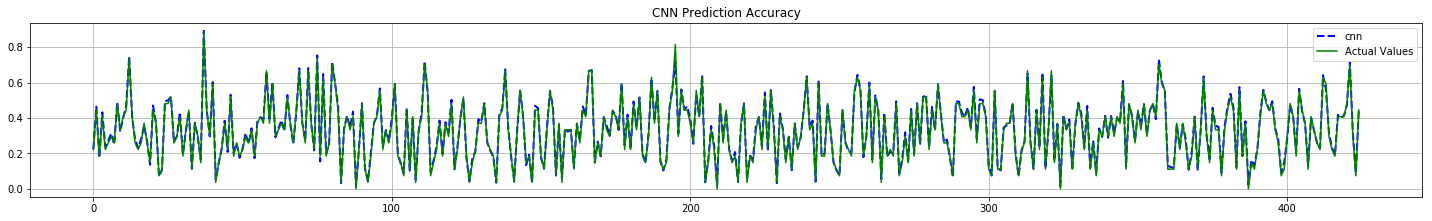

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
axes = fig.add_subplot(1, 1, 1)
line1,=axes.plot(range(len(prediction_value)), prediction_value, 'b--',label='cnn',linewidth=2)
line2,=axes.plot(range(len(test_y)), test_y, 'g',label='Actual Values')
axes.grid()
fig.tight_layout()

plt.legend(handles=[line1,  line2])
plt.title('CNN Prediction Accuracy')
plt.show()

In [28]:
RMSE_SUM = 0  # 用于计算RMSE
diff = [0 for i in range(len(test_y))]  # 误差的方差
for i in range(len(test_y)):
    diff[i] = prediction_value[i]-test_y[i]
    RMSE_SUM += pow(diff[i],2)
RMSE = pow(RMSE_SUM/len(test_y),0.5)
var_prediction = np.var(diff)
print(RMSE, var_prediction)

[0.01576493] 1.610812248187082e-07
